In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from scipy import optimize

%matplotlib inline
import matplotlib.pyplot as plt

from data_functions import generate_toy_data, get_bootstrap_data, set_intensity, get_data_to_fit
from data_functions import get_attenuation_parameters


In [2]:
# input parameters for the simualtions
minE = 10**15 #eV
maxE = 10**18 #eV
gamma = -2.5 # slope of the spectrum

#relation between energy and s38
A = 10**12
B = 1.2

#attenuation true numbers
alpha = 0.919
beta = -1.13

# Maximum zenith angle in degrees
maxTheta = 50

#number of events to generate
events = 10000
#number of bins for the zenith 
nr_of_bins = 8

data = generate_toy_data(events, minE, maxE, gamma, A, B, alpha, beta, maxTheta)

#print(data)

(array([115.,  95., 115., 104.,  82.,  92., 112., 108., 103., 117.,  86.,
        108.,  88., 111., 121.,  93.,  97., 106.,  89., 100., 111.,  98.,
         97.,  98.,  98.,  98., 101.,  98., 110., 114., 113., 101., 120.,
        108., 117., 113., 101.,  95.,  91., 103.,  90.,  99., 104., 111.,
        102.,  88., 100.,  81.,  91.,  81., 103.,  98., 101.,  80.,  99.,
         90.,  98., 100., 100., 108.,  79., 100.,  99.,  89., 103., 105.,
        103., 107., 102., 120.,  98.,  99.,  93., 101.,  95.,  94., 106.,
        101.,  99.,  97.,  89.,  97., 115., 103., 102.,  98., 111., 103.,
         91.,  77., 102.,  98.,  99., 104., 101.,  91.,  79.,  97.,  92.,
        110.]),
 array([0.41319003, 0.41905789, 0.42492575, 0.4307936 , 0.43666146,
        0.44252932, 0.44839718, 0.45426504, 0.4601329 , 0.46600076,
        0.47186862, 0.47773648, 0.48360434, 0.4894722 , 0.49534006,
        0.50120791, 0.50707577, 0.51294363, 0.51881149, 0.52467935,
        0.53054721, 0.53641507, 0.54228293, 0.

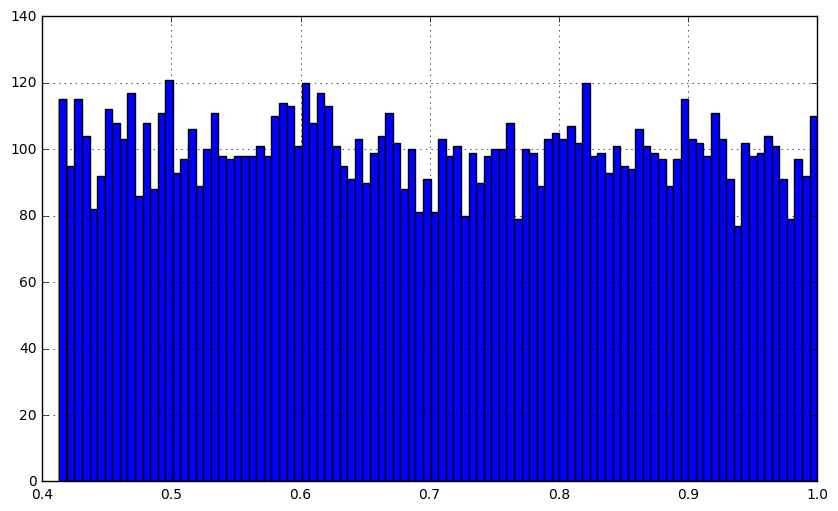

In [3]:
fig1, ax1 =plt.subplots(figsize=(10,6))
plt.grid()

ax1.hist(data.cos2,bins=100 )


In [4]:
#### fit the attenuation curve
data = set_intensity(data, nr_of_bins)
#print(data)        
    
### input value the reference intesity
intensity = 100
s125_fit, bins2, s38_fit , s125_fit_error= get_data_to_fit(data, intensity, nr_of_bins)
print(bins2)
values, cov = get_attenuation_parameters(s125_fit, bins2)

print(values)

[0.45510503 0.53893502 0.62276502 0.70659501 0.79042501 0.87425501
 0.958085  ]
[  0.95973709  -1.18742818 752.7508774 ]


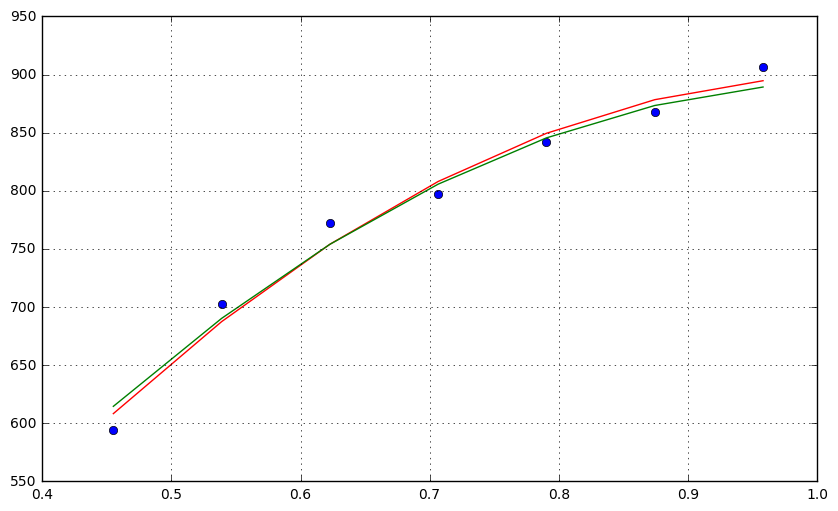

In [5]:
fig2, ax2 =plt.subplots(figsize=(10,6))
plt.grid()
from data_functions import get_s125 
a1=values[0]
a2=values[1]
a3=values[2]
y=get_s125(bins2, a1,a2,a3)
y2=get_s125(bins2, alpha, beta, a3)

ax2.plot(bins2, s125_fit, lw=0, marker='o')
ax2.plot(bins2,y, color="r")
ax2.plot(bins2,y2)

(2, 4)

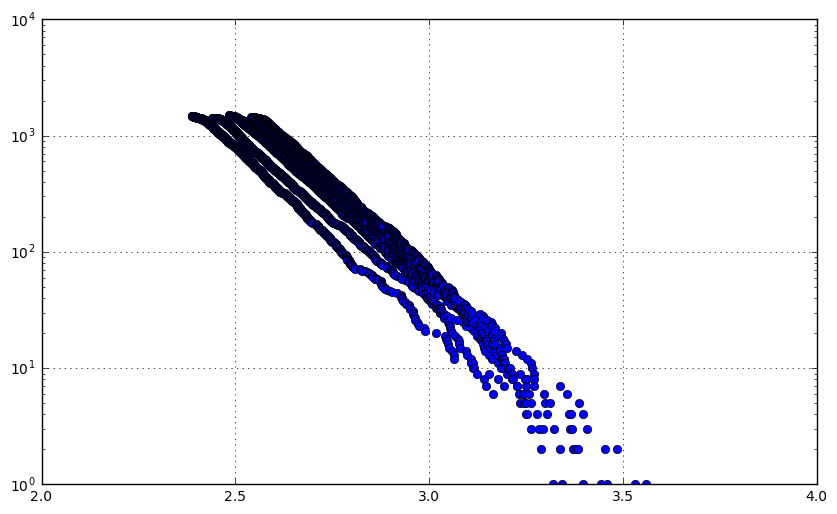

In [6]:
#groups = dict(list(data))
#print(groups)


    
fig1, ax1 =plt.subplots(figsize=(10,6))
plt.grid()

ax1.plot(np.log10(data.s125),data.I, lw=0, marker='o' )
ax1.set_yscale('log')
ax1.set_xlim(2,4)



[  0.94286675  -0.87439354 746.67086373]
[  0.97424226  -1.34875417 753.01624132]


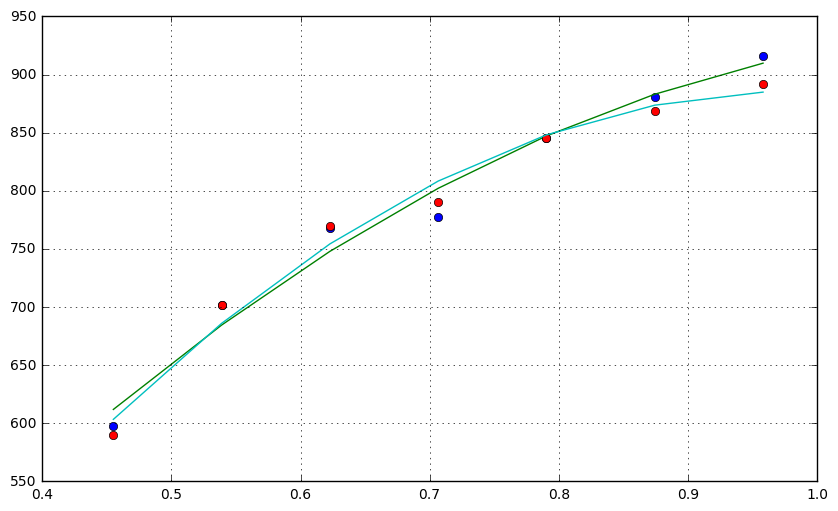

In [7]:
### number of boostrap samples as input
samples = 2
from data_functions import get_s125

fig2, ax2 = plt.subplots(figsize=(10,6))
plt.grid()
a=[alpha,beta,1]
bootstrap_values=[]
bootstrap_values_2=[]
for j in range(0, samples):
    new_data = get_bootstrap_data(data)
    new_data=set_intensity(new_data, nr_of_bins)
    s125_fit, bins, s38_fit, s125_fit_error = get_data_to_fit(new_data, intensity, nr_of_bins)
    vals, cov_bt = get_attenuation_parameters(s125_fit, bins)
    bootstrap_values.append(vals)
    bootstrap_values_2.append(vals**2)
    ax2.plot(bins, s125_fit, lw=0, marker='o')
    ax2.plot(bins, get_s125(bins, vals[0], vals[1], vals[2]))
    print(vals)


Things to do:
1. From the bootstrap get all the values and plot them in an histogram and one vs each other (in one canvas)
2. Give final results: values(from original data) +- rms(vals)
3. Implement MCMC fit in the get_attenuation_parameters function
4. Compare results with 2.
5. See/write to Ioana/Zig

In [8]:
from data_functions import get_attenuation_parameters2

params_scipy, cov2 = sp.optimize.curve_fit(get_s125, bins, s125_fit)
# Use as guess
a_true = params_scipy[0]
b_true = params_scipy[1]
f_true = params_scipy[2]

#final_parameters, cov2, sample = get_attenuation_parameters2(s125_fit, s38_fit, s125_fit_error, bins, performMCMC=True)
sample = get_attenuation_parameters2(params_scipy, s125_fit, s38_fit, s125_fit_error, bins)

/Library/Python/2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Library/Python/2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


Life is amazing


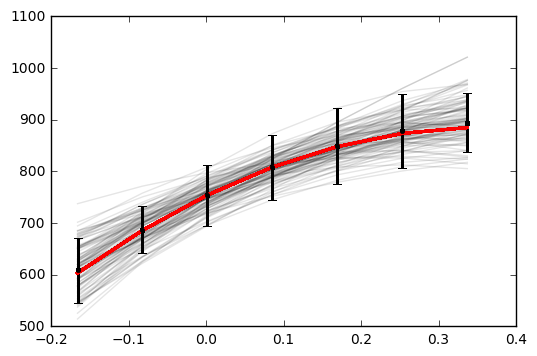

In [9]:
import math
cos_ref = np.cos(math.radians(38))**2
cos2 = bins - cos_ref
# Plot a subset of the samples
for a, b, f in sample[np.random.randint(len(sample), size=100)]:
    plt.plot(cos2, f * (b * cos2**2 + a * cos2 + 1), color="k", alpha=0.1)
    plt.plot(cos2, f_true * (b_true * cos2**2 + a_true * cos2 + 1), color="r", lw=2, alpha=0.8)
    plt.errorbar(cos2, y, yerr=s125_fit_error, fmt=".k")

/Library/Python/2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Python/2.7/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


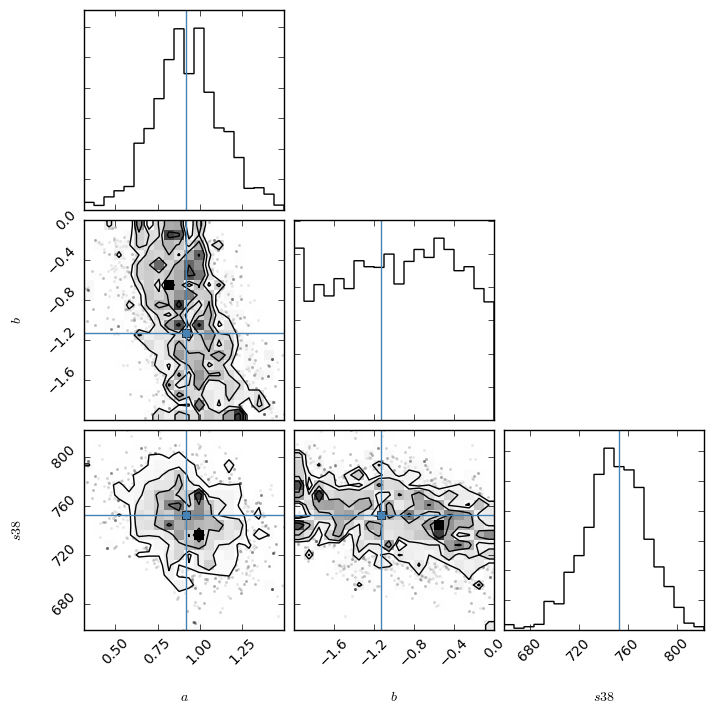

In [10]:
import corner
fig = corner.corner(sample, labels=["$a$","$b$", "$s38$"], truths=[alpha,beta, a3])
fig.savefig("")

In [11]:
a_mcmc,  b_mcmc,  s38_mcmc  = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(sample, [16, 50, 84],
                                                axis=0)))

#(mid_value, +error, -error)
print("a = %f + %f - %f\n"%(a_mcmc[0],a_mcmc[1],a_mcmc[2]))
print("b = %f + %f - %f\n"%(b_mcmc[0],b_mcmc[1],b_mcmc[2]))
print("s38 = %f + %f - %f\n"%(s38_mcmc[0],s38_mcmc[1],s38_mcmc[2]))

a = 0.915722 + 0.204158 - 0.185161

b = -0.971333 + 0.624521 - 0.679446

s38 = 750.182598 + 24.507449 - 25.208388

